<a href="https://colab.research.google.com/github/chararchter/intent-detection/blob/master/intent_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
# !pip install datasets
# !pip install PyGithub
# !pip install dagshub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.0 MB/s 
     |████████████████████████████████| 7.6 MB 40.4 MB/s 
     |████████████████████████████████| 182 kB 43.8 MB/s 


In [38]:
import os
from pathlib import Path
from typing import List

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import BertTokenizer, TFBertModel

# to mount google drive and access NLU-datasets
from google.colab import drive

# imports from NLU-datasets
import tensorflow as tf

from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers import (Dense, Activation, Conv1D, MaxPooling1D, 
                          Dropout, Flatten, Input, Add, Average,
                          LSTM, Lambda, AveragePooling1D,
                          Reshape)
from keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

Mount google drive to access NLU-datasets https://github.com/tilde-nlp/NLU-datasets that I presaved in my google drive in NLU-datasets directory. This will trigger a pop up window that asks for permission to access google drive.

TODO: Upload it to huggingface and use directly from there https://huggingface.co/docs/datasets/upload_dataset (the dataset has Creative Commons Attribution-ShareAlike 4.0 International License, which allows it)

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if "NLU-datasets" not in os.getcwd():
  os.chdir("drive/My Drive/NLU-datasets")

In [5]:
!ls

askubuntu  chatbot  README.md  webapps


In [6]:
def get_data(path: str) -> List[str]:
  with open(path) as f:
    array = []
    for line in list(f):
      array.append(line.split('\n')[0])
    return array


pathlist = Path("chatbot").glob("**/*.txt")

for path in pathlist:
  # because path is object not string
  path_in_str = str(path)
  print(path_in_str)
  if path_in_str == "chatbot/chatbot_train_ans.txt":
    chatbot_train_ans = get_data(path_in_str)
  elif path_in_str == "chatbot/chatbot_test_ans.txt":
    chatbot_test_ans  = get_data(path_in_str)
  elif path_in_str == "chatbot/en/chatbot_test_q.txt":
    en_test  = get_data(path_in_str)
  elif path_in_str == "chatbot/en/chatbot_train_q.txt":
    en_train  = get_data(path_in_str)
  elif path_in_str == "chatbot/lv/chatbot_test_q.txt":
    lv_test  = get_data(path_in_str)
  elif path_in_str == "chatbot/lv/chatbot_train_q.txt":
    lv_train  = get_data(path_in_str)

print(chatbot_train_ans)
print(chatbot_test_ans)
print(en_test)

chatbot/chatbot_train_ans.txt
chatbot/chatbot_test_ans.txt
chatbot/en/chatbot_test_q.txt
chatbot/en/chatbot_train_q.txt
chatbot/lv/chatbot_test_q.txt
chatbot/lv/chatbot_train_q.txt
chatbot/et/chatbot_train_q.txt
chatbot/et/chatbot_test_q.txt
chatbot/ru/chatbot_train_q.txt
chatbot/ru/chatbot_test_q.txt
chatbot/lt/chatbot_test_q.txt
chatbot/lt/chatbot_train_q.txt
['FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'DepartureTime', 'FindConnection', 'FindConnection', 'DepartureTime', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'FindConnection', 'DepartureTime', 'DepartureTime', 'DepartureTime', 'DepartureTime', 'DepartureT

In [23]:
set(chatbot_train_ans)

{'DepartureTime', 'FindConnection'}

what tokenizer does? what model does?

enconded_input shape changes by increasing word count: 4 words: (1, 6), 5 words: (1, 9); 7 words: (1, 13) what shape should go into classifier? sentence vector or individual word vectors? what do input_ids, token_type_ids and attention_mask mean in encoded_input? which one should i pass to classifier? probably input_ids because its the only one different from 0 and 1


In [7]:
model_name = "bert-base-multilingual-cased"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [8]:
encoded_input = tokenizer(en_test[0], return_tensors='tf')
output = model(encoded_input)

print(encoded_input)
print(output)

{'input_ids': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=
array([[  101,   177, 21528, 10114, 11783, 24538, 10136, 20732,   102]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 9, 768), dtype=float32, numpy=
array([[[-0.0801833 ,  0.03810789,  0.27046832, ...,  0.39124045,
         -0.11388008, -0.04561074],
        [-0.13535473, -0.6108815 ,  0.83754236, ...,  0.6064944 ,
         -0.36229718,  0.06997184],
        [-0.9340397 , -0.27897662,  0.34910232, ...,  1.0008135 ,
         -0.27053487,  0.39220354],
        ...,
        [-0.6494424 ,  0.01610382,  0.0694848 , ...,  0.9110728 ,
         -0.33973166, -0.44170994],
        [-0.43948   ,  0.11157995,  0.09911817, ...,  0.7545627 ,
          0

In [9]:
encoded_input['input_ids']

<tf.Tensor: shape=(1, 9), dtype=int32, numpy=
array([[  101,   177, 21528, 10114, 11783, 24538, 10136, 20732,   102]],
      dtype=int32)>

In [10]:
encoded_input['token_type_ids']

<tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

In [11]:
encoded_input['attention_mask']

<tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>

In [12]:
output["last_hidden_state"]

<tf.Tensor: shape=(1, 9, 768), dtype=float32, numpy=
array([[[-0.0801833 ,  0.03810789,  0.27046832, ...,  0.39124045,
         -0.11388008, -0.04561074],
        [-0.13535473, -0.6108815 ,  0.83754236, ...,  0.6064944 ,
         -0.36229718,  0.06997184],
        [-0.9340397 , -0.27897662,  0.34910232, ...,  1.0008135 ,
         -0.27053487,  0.39220354],
        ...,
        [-0.6494424 ,  0.01610382,  0.0694848 , ...,  0.9110728 ,
         -0.33973166, -0.44170994],
        [-0.43948   ,  0.11157995,  0.09911817, ...,  0.7545627 ,
          0.09094203, -0.18004183],
        [-0.28581655, -0.2066401 ,  1.011272  , ...,  0.43730482,
         -0.19045137,  0.07825352]]], dtype=float32)>

In [13]:
output["last_hidden_state"][-1][-1]

<tf.Tensor: shape=(768,), dtype=float32, numpy=
array([-2.85816550e-01, -2.06640095e-01,  1.01127195e+00,  1.69524789e-01,
        4.14486468e-01,  4.47487116e-01, -8.07733417e-01, -3.04689705e-02,
        6.30858660e-01,  1.63276047e-01,  4.42681983e-02,  2.33404160e-01,
        2.33043700e-01,  9.90202278e-02,  7.55258724e-02, -3.19861799e-01,
        1.78901076e-01,  1.21485829e+00,  4.84492630e-02,  3.46210957e-01,
        1.32623047e-01, -1.11739606e-01, -6.08281076e-01, -8.09178874e-02,
        6.48078918e-01, -8.46023560e-02, -6.56183779e-01,  5.01036823e-01,
       -3.52555275e-01, -1.67582184e-01,  1.31201491e-01,  1.03604145e-01,
        6.91109747e-02, -2.77196527e-01,  3.67442280e-01,  1.57708317e-01,
       -2.31118575e-01, -2.12884232e-01, -2.05561444e-01, -3.60636175e-01,
       -5.36699355e-01,  3.67783606e-01,  5.39835542e-02,  1.12441890e-02,
        8.39076161e-01, -2.81842530e-01,  3.12413156e-01,  2.32986048e-01,
        4.03371036e-01, -6.85853481e-01,  4.51511323

docs: https://huggingface.co/transformers/v3.0.2/model_doc/bert.html


**batch_size** -  number of data points sampled to calculate the gradient on each iteration

large vs small batch size performance table2 https://arxiv.org/pdf/1609.04836.pdf

**sequence_length** -  number of tokens (words) in a sentence. causes the layer to pad or truncate sequences to exactly sequence_length values. how to handle variable-length inputs (sentences of different lengths)?

**hidden_size** (int, optional, defaults to 768) — Dimensionality of the encoder layers and the pooler layer.

**last_hidden_state** (tf.Tensor of shape (batch_size, sequence_length, hidden_size)) — Sequence of hidden-states at the output of the last layer of the model.


**pooler_output** (tf.Tensor of shape (batch_size, hidden_size)) — Last layer hidden-state of the first token of the sequence (classification token) further processed by a Linear layer and a Tanh activation function. The Linear layer weights are trained from the next sentence prediction (classification) objective during pretraining.

This output is usually not a good summary of the semantic content of the input, you’re often better with averaging or pooling the sequence of hidden-states for the whole input sequence.

https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.BaseModelOutputWithPooling


**Tokenization** - splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).

**Vectorization** - converting tokens into numbers so they can be fed into a neural network. 

https://www.tensorflow.org/tutorials/keras/text_classification

In [14]:
# which one (last_hidden_state or pooler_output) should be passed to classifier?
# i guess try both and see how it works
output

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 9, 768), dtype=float32, numpy=
array([[[-0.0801833 ,  0.03810789,  0.27046832, ...,  0.39124045,
         -0.11388008, -0.04561074],
        [-0.13535473, -0.6108815 ,  0.83754236, ...,  0.6064944 ,
         -0.36229718,  0.06997184],
        [-0.9340397 , -0.27897662,  0.34910232, ...,  1.0008135 ,
         -0.27053487,  0.39220354],
        ...,
        [-0.6494424 ,  0.01610382,  0.0694848 , ...,  0.9110728 ,
         -0.33973166, -0.44170994],
        [-0.43948   ,  0.11157995,  0.09911817, ...,  0.7545627 ,
          0.09094203, -0.18004183],
        [-0.28581655, -0.2066401 ,  1.011272  , ...,  0.43730482,
         -0.19045137,  0.07825352]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 0.24232769, -0.05618593,  0.26164392, -0.1876519 , -0.06455278,
         0.4678913 ,  0.2218737 ,  0.21415153, -0.42583662,  0.2915675 ,
        -0.11752243, -0.1815

In [20]:
output["last_hidden_state"]

<tf.Tensor: shape=(1, 9, 768), dtype=float32, numpy=
array([[[-0.0801833 ,  0.03810789,  0.27046832, ...,  0.39124045,
         -0.11388008, -0.04561074],
        [-0.13535473, -0.6108815 ,  0.83754236, ...,  0.6064944 ,
         -0.36229718,  0.06997184],
        [-0.9340397 , -0.27897662,  0.34910232, ...,  1.0008135 ,
         -0.27053487,  0.39220354],
        ...,
        [-0.6494424 ,  0.01610382,  0.0694848 , ...,  0.9110728 ,
         -0.33973166, -0.44170994],
        [-0.43948   ,  0.11157995,  0.09911817, ...,  0.7545627 ,
          0.09094203, -0.18004183],
        [-0.28581655, -0.2066401 ,  1.011272  , ...,  0.43730482,
         -0.19045137,  0.07825352]]], dtype=float32)>

In [21]:
output["last_hidden_state"].shape

TensorShape([1, 9, 768])

In [25]:
output["last_hidden_state"].shape[-1]

768

In [16]:
# model = tf.keras.Sequential([
#   layers.Embedding(max_features + 1, embedding_dim),
#   layers.Dropout(0.2),
#   layers.GlobalAveragePooling1D(),
#   layers.Dropout(0.2),
#   layers.Dense(1)])

# model.summary()

In [32]:
# This model is not used (as CNN is better).
# This would require sentence vector as input (instead of word vectors)
# how to get sentence vector?
def createModel1(vectorSpaceSize, nClasses, **kwargs):
    model = Sequential()
    model.add(Dense(nClasses, input_dim=vectorSpaceSize, activation='softmax'))
    return model

In [33]:
# is nClasses the number of different classes im trying to classify? in that case its 2
# {'DepartureTime', 'FindConnection'}

createModel1(vectorSpaceSize=output["last_hidden_state"].shape[-1], nClasses=2)

In [34]:
def createAdamOptimizer(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0, epsilon=None, amsgrad=False):
    return Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, decay=decay, amsgrad=amsgrad)

learning_rate = 0.03
optimizer = createAdamOptimizer(lr=learning_rate)

In [35]:
model.compile(optimizer=optimizer,
              #loss='categorical_crossentropy',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

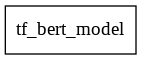

In [36]:
plot_model(model)

In [40]:
logDir = "."
tbCallBack = TensorBoard(log_dir=logDir, histogram_freq=0, # histogram_freq=1,
        write_graph=True, write_images=True)

with open(os.path.join(logDir, 'params.txt'), 'w', encoding='utf-8', buffering=1) as out:
  out.write(model.to_json() + "\n\n")
  model.summary(print_fn=lambda x: out.write(x + '\n'))
  out.write("\n")

In [42]:
# TODO:  en_test  ->  encoded_input -> output -> classifier(output["pooler_output"]) -> ????? ->  testX, testY

In [41]:
history = model.fit(trainX, trainY, epochs=epochs, verbose=0,
    callbacks=[tbCallBack, CustomCallback()],
    validation_data=(testX, testY),
)
model.save(os.path.join(logDir, "model.hdf"))

NameError: ignored